In [1]:
# Libraries for downloading data from FTP
import shutil
import urllib.request as req
from contextlib import closing

# Library for uploading data to S3
import boto3

# Libraries for handling data
import rasterio as rio
import pandas as pd
import numpy as np

# Libraries for various helper functions
from datetime import datetime
import os
import threading
import sys

cli.005.1 https://nsidc.org/data/docs/noaa/g02135_seaice_index/#text_summary
SRC: ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/geotiff/01_Jan (etc)
files look like: N_197901_concentration_v2.1.tif, N_197901_extent_v2.1.tif
from Jan 1979
File type: tif
North Polar Projection

cli.005.2 https://nsidc.org/data/docs/noaa/g02135_seaice_index/#text_summary
SRC: ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/south/monthly/geotiff/01_Jan (etc)
files look like: S_197901_concentration_v2.1.tif
from Jan 1979
File type: tif
Antarctic Projection

In [ ]:
## Need to know - how often do they update?

# This could run every day... there won't necessarily be anything to add
# In that case perhaps it should return an error to some console
# It would be nice for RW staff to see what has been updated
# And what updates were attempted but found nothing new


In [2]:
# Directions for how to read contents of an FTP directory
# https://stackoverflow.com/questions/2289768/python-and-urllib
remote_path_north = "ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/geotiff/"
remote_path_south = "ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/south/monthly/geotiff/"
file = req.urlopen(remote_path_north).read().splitlines()
file

[b'drwxr-xr-x   14 500        9474               14 Aug 16 18:04 .',
 b'drwxr-xr-x    6 500        9474                6 Aug 16 18:04 ..',
 b'drwxr-xr-x    2 500        9474               78 Oct 20 09:32 01_Jan',
 b'drwxr-xr-x    2 500        9474               80 Oct 20 09:32 02_Feb',
 b'drwxr-xr-x    2 500        9474               80 Oct 20 09:32 03_Mar',
 b'drwxr-xr-x    2 500        9474               80 Oct 20 09:32 04_Apr',
 b'drwxr-xr-x    2 500        9474               80 Oct 20 09:32 05_May',
 b'drwxr-xr-x    2 500        9474               80 Oct 20 09:32 06_Jun',
 b'drwxr-xr-x    2 500        9474               80 Oct 20 09:32 07_Jul',
 b'drwxr-xr-x    2 500        9474               79 Oct 20 09:32 08_Aug',
 b'drwxr-xr-x    2 500        9474               80 Oct 20 09:32 09_Sep',
 b'drwxr-xr-x    2 500        9474               80 Jan  2 11:10 10_Oct',
 b'drwxr-xr-x    2 500        9474               82 Jan  2 11:10 11_Nov',
 b'drwxr-xr-x    2 500        9474             

In [28]:
def format_month(mon):
    if mon == 0:
        return("12")
    elif mon < 0:
        if mon > -2:
            return(str(12 + mon))
        else:
            return("0" + str(12 + mon))
    elif mon < 10:
        return("0" + str(mon))
    else:
        return(str(mon))
    

now = datetime.now()
year = str(now.year-1)
month = format_month(now.month-6)
print(now.month, month, year)

def create_most_recent_file(year, month, north_or_south="N"):
    # file_type in [extent, concentration]
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
              "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    return("{}_{}/{}_{}{}_extent_v3.0.tif".format(month,months[int(month)-1],north_or_south, year, month))

arctic_file = create_most_recent_file(year, month, "N")
antarctic_file = create_most_recent_file(year, month, "S")

1 07 2017


In [24]:
antarctic_file

'07_Jul/S_201707_extent_v2.1.tif'

In [31]:
ftp_arctic = remote_path_north+arctic_file
ftp_antarctic = remote_path_south+antarctic_file
print(ftp_arctic)
print(ftp_antarctic)

local_folder = "/Users/nathansuberi/Desktop/RW_Data/Polar_Sea_Ice/"
# Use 7: to not include the month's folder in the local file name
arctic_file_name = arctic_file[7:]
antarctic_file_name = antarctic_file[7:]

local_arctic_orig = local_folder+arctic_file_name
local_antarctic_orig = local_folder+antarctic_file_name

local_arctic_edit = local_arctic_orig[:-4] + "_edit.tif"
local_antarctic_edit = local_antarctic_orig[:-4] + "_edit.tif"

with closing(req.urlopen(ftp_arctic)) as r:
    with open(local_arctic_orig, 'wb') as f:
        shutil.copyfileobj(r, f)
         
with closing(req.urlopen(ftp_antarctic)) as r:
    with open(local_antarctic_orig, 'wb') as f:
        shutil.copyfileobj(r, f)

ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/geotiff/07_Jul/N_201707_extent_v3.0.tif
ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/south/monthly/geotiff/07_Jul/S_201707_extent_v3.0.tif


In [62]:
from rasterio.warp import calculate_default_transform, reproject
import rasterio

def reproject_file(orig_name, edit_name):
    with rasterio.open(orig_name, 'r') as src:
        # This assumes data is readable by rasterio
        # May need to open instead with netcdf4.Dataset, for example
        print(src.crs)
        dst_crs = 'EPSG:4326'
        transform, width, height = calculate_default_transform(src.crs, dst_crs, 
                                                               src.width, src.height, 
                                                               *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height,
            'compress':'lzw'
        })

        with rasterio.open(edit_name, "w", **kwargs) as dst:
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs)

reproject_file(local_arctic_orig, local_arctic_edit)
reproject_file(local_antarctic_orig, local_antarctic_edit)

CRS({'init': 'epsg:3411'})
CRS({'init': 'epsg:3412'})


In [ ]:
import os
def reproject_file(orig_name, edit_name):
    with rasterio.open(orig_name, 'r') as src:
        # This assumes data is readable by rasterio
        # May need to open instead with netcdf4.Dataset, for example
        print(src.crs)
        !gdalwarp -overwrite -s_srs 

reproject_file(local_arctic_orig, local_arctic_edit)
reproject_file(local_antarctic_orig, local_antarctic_edit)

In [100]:
with rio.open(local_arctic_orig) as src:
    arctic_pro = src.profile
    arctic_data = src.read(indexes=1)
    arctic_bounds = src.bounds
    
with rio.open(local_antarctic_orig) as src:
    antarctic_pro = src.profile
    antarctic_data = src.read(indexes=1)
    antarctic_bounds = src.bounds

In [101]:
arctic_pro

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 304, 'height': 448, 'count': 1, 'crs': CRS({'init': 'epsg:3411'}), 'transform': Affine(25000.0, 0.0, -3850000.0,
       0.0, -25000.0, 5850000.0), 'tiled': False, 'interleave': 'band'}

In [102]:
antarctic_pro

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 316, 'height': 332, 'count': 1, 'crs': CRS({'init': 'epsg:3412'}), 'transform': Affine(25000.0, 0.0, -3950000.0,
       0.0, -25000.0, 4350000.0), 'tiled': False, 'interleave': 'band'}

In [69]:
arctic_bounds

BoundingBox(left=-178.15733969334627, bottom=30.9099890253481, right=177.62359256195185, top=56.275851787994355)

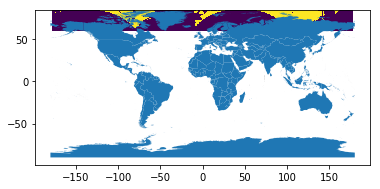

In [83]:
from matplotlib import pyplot as plt
import geopandas as gpd
%matplotlib inline

# World country boundaries for context
country_bounds = gpd.read_file("/Users/nathansuberi/Desktop/RW_Data/all_countries/all_countries.shp")
country_bounds = country_bounds[["geometry", "name"]]

b = arctic_bounds
plt.imshow(arctic_data, extent = [b[0], b[2], 90-b[1], 90-(b[1]-abs(b[3]-b[1]))])
ax = plt.gca()
country_bounds.plot(ax=ax)

In [72]:
antarctic_bounds

BoundingBox(left=-179.99991257357857, bottom=-54.70000483751825, right=179.6570445922746, top=-39.23088840027726)

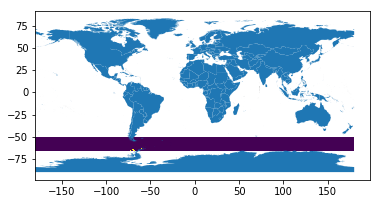

In [96]:
from matplotlib import pyplot as plt
import geopandas as gpd
%matplotlib inline

# World country boundaries for context
country_bounds = gpd.read_file("/Users/nathansuberi/Desktop/RW_Data/all_countries/all_countries.shp")
country_bounds = country_bounds[["geometry", "name"]]
    
b = antarctic_bounds
plt.imshow(antarctic_data, extent = [b[0], b[2], -90-(b[3]+abs(b[3]-b[1])), -90-b[3]])
ax = plt.gca()
country_bounds.plot(ax=ax)

In [ ]:
### NOTE = THIS WILL KEEP REPLACING THE FILE WITH THE NEWEST VERSION

# S3 destinations
s3_bucket = "wri-public-data"
s3_folder = "resourcewatch/raster/"

s3_file_antarctic = "cli_005_antarctic_sea_ice_extent.tif"
s3_key_antarctic_orig = s3_folder + s3_file_antarctic
s3_key_antarctic_edit = s3_key_antarctic_orig[:-4] + "_edit.tif"

s3_file_arctic = "cli_006_arctic_sea_ice_extent.tif"
s3_key_arctic_orig = s3_folder + s3_file_arctic
s3_key_arctic_edit = s3_key_arctic_orig[:-4] + "_edit.tif"

# S3 services
s3_download = boto3.resource("s3")
s3_upload = boto3.client("s3")

# Helper function to view upload progress
class ProgressPercentage(object):
        def __init__(self, filename):
            self._filename = filename
            self._size = float(os.path.getsize(filename))
            self._seen_so_far = 0
            self._lock = threading.Lock()

        def __call__(self, bytes_amount):
            # To simplify we'll assume this is hooked up
            # to a single filename.
            with self._lock:
                self._seen_so_far += bytes_amount
                percentage = (self._seen_so_far / self._size) * 100
                sys.stdout.write(
                    "\r%s  %s / %s  (%.2f%%)" % (
                        self._filename, self._seen_so_far, self._size,
                        percentage))
                sys.stdout.flush()

In [ ]:
# Originals
s3_upload.upload_file(local_arctic, s3_bucket, s3_key_arctic_orig,
                         Callback=ProgressPercentage(local_arctic))

s3_upload.upload_file(local_antarctic, s3_bucket, s3_key_antarctic_orig,
                         Callback=ProgressPercentage(local_antarctic))

# Edits
s3_upload.upload_file(local_arctic_edit, s3_bucket, s3_key_arctic_edit,
                         Callback=ProgressPercentage(local_arctic_edit))

s3_upload.upload_file(local_antarctic_edit, s3_bucket, s3_key_antarctic_edit,
                         Callback=ProgressPercentage(local_antarctic_edit))